In [ ]:
# Based on https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [1]:
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from datetime import datetime
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
from torchvision.transforms import ToTensor

from koger_detection.obj_det.engine import train, get_detection_model
from koger_detection.obj_det.engine import collate_fn, worker_init_fn
from koger_detection.obj_det.mydatasets import CocoDetection
from koger_detection.utils.dataset import get_ious
from koger_detection.utils.lr_scheduler import get_lr_scheduler

/home/koger/environments/salmon/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Specify training config and build training model based on config

In [3]:
# Assumes we have a local .env file that stores things like ROOT
load_dotenv()

root = os.environ.get("ROOT")
research_project = "high-elevation"

# This will be added to the saved config file for this training run
model_run_readme = "First training with train_annotations_2_12_24. Using full current augmentaion regieme." 

# ----------- SPECIFY TRAINING AND VALIDATION SET -----------------------------------

# Paths to training/val images and .json files that store corresponding annoations
image_folder = os.path.join(root, "annotations", research_project, "images")
train_json_path = os.path.join(root, "annotations", research_project, "train_annotations_2_12_24.json")
val_json_path = os.path.join(root, "annotations", research_project, "val_annotations_4_24_23.json")


# --------- BUILD EXAMPLE TRAIN AND VAL DATASETS WITH SPECIFIED DATA ------------------
# Note: These will not be used for the actual training. 
# Used to set number of classes and initial visualizatations.

bbox_params = A.BboxParams(
    format='pascal_voc', label_fields=['class_labels', 'area']
)

base_transform  = A.Compose([
    A.ToFloat(max_value=255),
    ToTensorV2()
], bbox_params=bbox_params)

train_dataset = CocoDetection(image_folder,
                              train_json_path,
                              transform=base_transform)

val_dataset = CocoDetection(image_folder,
                            val_json_path,
                            transform=base_transform)

# Find the most annotations in a single image in training set
# Important for setting certain hyperparameters (i.e. rpn_batch_size_per_image etc.)
num_annotations = [d[1]['boxes'].shape[0] for d in train_dataset]
print(f"{len(train_dataset)} training images.")
print(f"max annoations per image {np.max(np.array(num_annotations))}")
class_labels = [int(torch.unique(d[1]['labels'])[0]) for d in train_dataset]
train_class_labels = max(class_labels)

# Find the most annotations in a single image in training set
# Important for setting certain hyperparameters (i.e. rpn_batch_size_per_image etc.)
num_annotations = [d[1]['boxes'].shape[0] for d in val_dataset]
print(f"{len(val_dataset)} validation images.")
print(f"max annoations per image {np.max(np.array(num_annotations))}")
class_labels = [int(torch.unique(d[1]['labels'])[0]) for d in val_dataset]
val_class_labels = max(class_labels)

# Background counts as a class (0) so need the + 1
num_classes = max([val_class_labels, train_class_labels]) + 1

print(f"{num_classes} object classes across the train and val annotations incl. background.")

# ---------- DEFINE TRAINING CONFIG FILE --------------------------------


# Where info about the training run will be saved (including run cfg)
now = datetime.now() # current date and time
date_time = now.strftime("%m-%d-%Y-%H-%M-%S")
model_path = os.environ.get("MODEL_PATH")
run_folder = os.path.join(model_path, research_project, "runs", "main", f"{date_time}")
os.makedirs(run_folder)


cfg = {'model':
           {'model_type': "bbox_v2",
            'num_classes': num_classes,
            'trainable_backbone_layers': 5,
            'rpn_batch_size_per_image': 256,
            'rpn_pre_nms_top_n_train': 4000,
            'rpn_post_nms_top_n_train': 2000,
            'rpn_pre_nms_top_n_test': 4000,
            'rpn_post_nms_top_n_test': 2000,
            'box_detections_per_img': 700,
            'box_nms_thresh': .7,
            'box_batch_size_per_image': 512,
            'box_positive_fraction': 0.5,
            'fixed_size': [1024, 1024]
           },
       'training': 
           {'image_folder': image_folder,
            'train_json_path': train_json_path,
            'val_json_path': val_json_path,
            'batch_size': 4,
            'num_workers': 4,
            'num_epochs': 5,
            'run_folder': run_folder,
            'epochs_per_val': 1,
            'optimizer':
                {'name': 'SGD',
                 'lr': 0.005, 
                 'momentum': 0.9,
                 'weight_decay': 0.0005
                },
            'lr_scheduler':
                {'name': 'ReduceOnPlateau',
                 'patience': 4,
                 'factor': .3
                }
           }
      }

# ---------- DEFINE AUGMENTAIONS -----------------------------


train_data_transform = A.Compose([
    A.ToFloat(max_value=255),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=.3),
    A.geometric.resize.RandomScale(.2, interpolation=cv2.INTER_LINEAR, p=.75),
    A.geometric.transforms.PadIfNeeded(min_height=1024, min_width=1024, 
                 border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
    A.crops.transforms.RandomCrop(1024, 1024, p=1.0),
    A.RandomBrightnessContrast(brightness_limit=.3, contrast_limit=.1, 
                                   brightness_by_max=True, p=.75),
    A.Blur(p=.1),
    ToTensorV2()
], bbox_params=bbox_params)

val_data_transform = A.Compose([
    A.ToFloat(max_value=255),
    ToTensorV2()
], bbox_params=bbox_params)

cfg['train_aug'] = train_data_transform.to_dict()
cfg['val_aug'] = val_data_transform.to_dict()

# --------- SAVE CFG ------------------------
cfg['readme'] = model_run_readme

#define the path for your json file
cfg_path = os.path.join(cfg['training']['run_folder'], "cfg.json")

# open your json file and add the dictionary
with open (cfg_path, 'w') as f:
    json.dump(cfg, f)
    
# -------- BUILD TRAINING MODEL BASED ON CFG -------------------

model = get_detection_model(**cfg['model'])
print("Model built.")
params = [p for p in model.parameters() if p.requires_grad]

cfg_t = cfg['training']
cfg_t['optimizer'].pop('name') # TODO use name to choose optimizer in seperate function
optimizer = torch.optim.SGD(params, **cfg_t['optimizer'])
lr_scheduler = get_lr_scheduler(optimizer, **cfg_t['lr_scheduler'])

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
235 training images.
max annoations per image 327
36 validation images.
max annoations per image 188
3 object classes across the train and val annotations incl. background.
Model built.


# Visualize augmented training images and annotations
WARNING: This is not the actual DataLoader instance used for training. It uses the same classes configured in the same way (except here shuffle=False) so should show correct effect of augmentation regieme and confirm that annotations and images are in the correct format for loading. However, even though everything looks correct here, if train() is changed to do something different this cell will no longer reflect the actual loading pipeline used. 

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


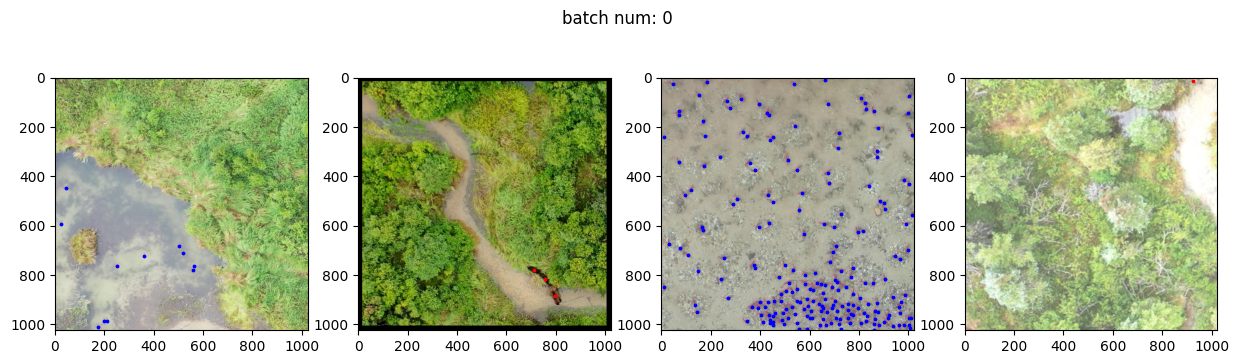

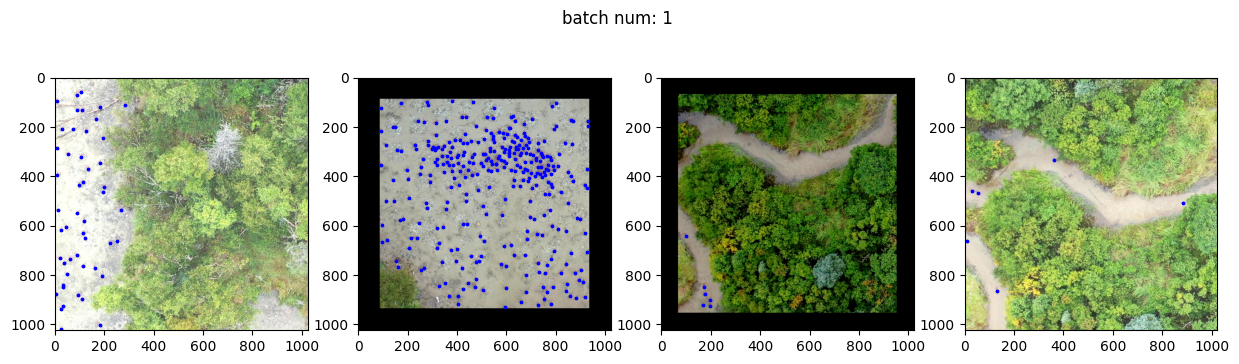

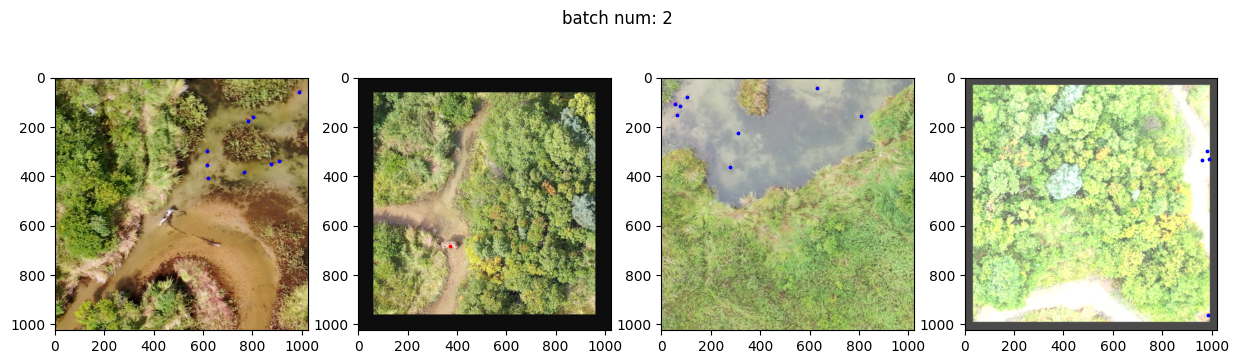

In [8]:
visualize = True
# First batch to visualize
first_batch_vis = 0
# Last batch to visualize
last_batch_vis = 3

# Must add more colors have more than 5 classes and want unique colors
class_colors = ["b", "r", "w", "g", "k"]

if visualize:
    
    train_dataset = CocoDetection(image_folder,
                                  train_json_path,
                                  transform=train_data_transform)

    data_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=cfg['training']['batch_size'], shuffle=False, 
            num_workers=cfg['training']['num_workers'], collate_fn=collate_fn,
            worker_init_fn=worker_init_fn
    )
    
    for ind, data in enumerate(data_loader):
        if ind < first_batch_vis:
            continue
        if ind >= last_batch_vis:
            break
        
        im_batch, tar_batch = data
        fig, axs = plt.subplots(1, 4, figsize=(15, 4))
        fig.suptitle(f"batch num: {ind}")
        for batch_ind, (im, tar) in enumerate(zip(im_batch, tar_batch)):
            im = im.permute(1, 2, 0).numpy()
            axs[batch_ind].imshow(im)
            boxes = tar['boxes']
            labels = tar['labels']
            for box, label in zip(boxes, labels):
                label = label - 1 # Don't give background class a color
                color = class_colors[label % len(class_colors)]
                box = box.numpy()
                axs[batch_ind].scatter(np.mean([box[0], box[2]]), np.mean([box[1], box[3]]), s=3, c=color)

# Train model

In [9]:
train(cfg, model, optimizer, lr_scheduler, train_data_transform,
      val_data_transform)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch: [0]  [ 0/59]  eta: 0:01:19  lr: 0.000091  loss: 2.7558 (2.7558)  loss_classifier: 1.1202 (1.1202)  loss_box_reg: 0.0192 (0.0192)  loss_objectness: 1.3387 (1.3387)  loss_rpn_box_reg: 0.2776 (0.2776)  time: 1.3402  data: 0.1979  max mem: 10683
Epoch: [0]  [50/59]  eta: 0:00:03  lr: 0.004397  loss: 1.0507 (1.7714)  loss_classifier: 0.2838 (0.5300)  loss_box_reg: 0.5634 (0.5712)  loss_objectness: 0.1272 (0.5117)  loss_rpn_box_reg: 0.0884 (0.1585)  time: 0.3769  data: 0.0021  max mem: 12090
Epoch: [0]  [58/59]  eta: 0:00:00  lr: 0.005000  loss: 0.9505 (1.6494)  loss_classifier: 0.2154 (0.4852)  loss_box_reg: 0.5578 (0.5666)  loss_objectness: 0.1061 (0.4525)  loss_rpn_box_reg: 0.0612 (0.1452)  time: 0.3722  data: 0.0022  max mem: 12473
Epoch: [0] Total time: 0:00:23 (0.3931 s / it)
Test:  [ 0/36]  eta: 0:00:15  model_time

# Check model output on some validation images

In [10]:
data_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False, 
        num_workers=4) #, collate_fn=collate_fn)

In [11]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

### Compare ground truth to predictions

In [ ]:
max_batch = 2
for ind, (images, tar) in enumerate(data_loader):
    if ind >= max_batch:
        break
    images = list(img.to(torch.device('cuda')) for img in images)
    # im = im[0]
    res = model(images)[0]
    boxes = res['boxes'].to('cpu').detach().numpy().astype(np.uint32)
    scores = res['scores'].to('cpu').detach().numpy()
    im = images[0].cpu().numpy().transpose(1, 2, 0).copy() # Copy makes circle work for unclear reasons
    im_preds = im.copy()
    for box, score in zip(boxes, scores):
        if score < .7:
            continue
        x = np.mean([box[0], box[2]])
        y = np.mean([box[1], box[3]])
        cv2.circle(im_preds, [int(x), int(y)], 3, (1.0, 0, 1.0), -1)
    for box in tar['boxes'][0]:
        box = box.numpy()
        x = np.mean([box[0], box[2]])
        y = np.mean([box[1], box[3]])
        cv2.circle(im_preds, [int(x), int(y)], 6, (1.0, 1.0, 1.0), 1)
        
        

        
    plt.figure(figsize=(10,10))
    plt.imshow(im_preds)
    print(len(boxes))